<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Pythonic Data Analysis</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://www.python.org/static/opengraph-icon-200x200.png" alt="Example Satellite Image" style="height: 200px;"></div>

One of the nice aspects of Python is that it contains many powerful tools built into the language itself:

- Date/Time support
- Iteration and unpacking
- dictionaries
- first-class functions
- filepath manipulation (standard library)

In this section we'll look at how to use these concepts to write simple, yet powerful data analysis scripts. We'll also look at how to improve on some of the basic plots we've made.

## Improved Time-Series Plotting

Let's start by opening a time series from the GFS to play with.

In [26]:
from netCDF4 import Dataset, num2date
data = Dataset('../../data/model-gfs.nc', 'r')

# Convert the array of time numbers to datetimes
time_var = data['time']
time = num2date(time_var[:], time_var.units).squeeze()

Now let's make a basic time series plot with matplotlib.

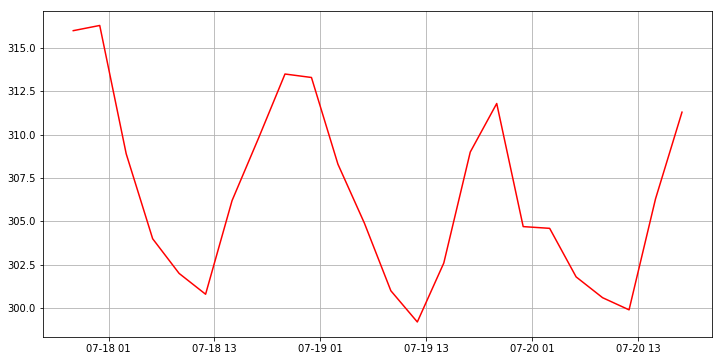

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# Just a single panel of time vs. Temperature_isobaric, which was taken from 1000mb
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(time, data.variables['Temperature_isobaric'][:].squeeze(), 'r-')
ax.grid()

Let's work a bit harder and add axis labels, set up some better date ticking, and format the grid lines to go with the new ticking so that we can more easily denote the days.

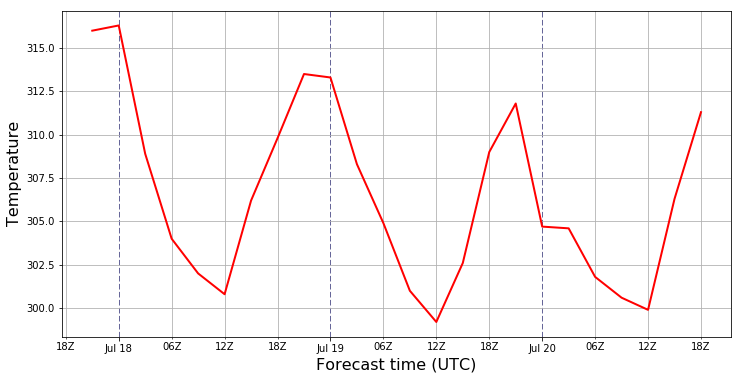

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(time, data.variables['Temperature_isobaric'][:].squeeze(), 'r-', linewidth=2)

# Add x/y axis labels with a bigger font
label_font = dict(size=16)
ax.set_xlabel('Forecast time (UTC)', fontdict=label_font)
ax.set_ylabel('Temperature', fontdict=label_font)

# Set the x-axis to do major ticks on the days and label them like 'Jul 20'
from matplotlib.dates import DateFormatter, DayLocator, HourLocator
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

# Set up minor ticks with the hours 6, 12, 18 written as '18Z'
ax.xaxis.set_minor_locator(HourLocator(range(6, 24, 6)))
ax.xaxis.set_minor_formatter(DateFormatter('%HZ'))

# Highlight the major x-axis grid lines with a thicker, dashed line
ax.grid(axis='x', linestyle='--', color='#666699', linewidth=1.0)
ax.grid(which='minor', axis='x')
ax.grid(axis='y')

## Containers and iteration

Python's built-in lists and tuples facilitate easy ways of looping over groups of data. One useful utility is ``zip``, which iterates over multiple lists at the same time and gives tuples of the elements.

In [29]:
vals = [1, 2, 3, 4]
names = ['one', 'two', 'three', 'four']
z = list(zip(names, vals))

Coincidentally, ``zip`` can also be used to unzip, using the ability of Python to pass a sequence as a set of positional arguments:

In [30]:
list(zip(*z))

[('one', 'two', 'three', 'four'), (1, 2, 3, 4)]

Another useful part of the containers is unpacking, which allows assignment directly from a container

In [31]:
one, two, three, four = vals
print(three)

3


This same functionality enables multiple return values from functions

In [32]:
import math
def polar_to_cartesian(r, th):
    x = r * math.cos(th)
    y = r * math.sin(th)
    return x, y

X,Y = polar_to_cartesian(2, math.pi / 3)
print(X, Y)

1.0000000000000002 1.7320508075688772


You can put those together and iterate over multiple lists, and unpack those items into individual variables:

In [33]:
for n, v in zip(names, vals):
    print('%s == %d' % (n, v))

one == 1
two == 2
three == 3
four == 4


Now let's add ``Relative_humidity_isobaric`` to our plot on a new subplot. But we need to do this in a loop without duplicating code. To do so we need:
- A list of variables to plot
- A way to convert the variable from the file to an axis label
- A list of plot formats

In [34]:
# This is just to keep the different cells in the notebook from rehashing this
def set_defaults(ax):
    # Set the x-axis to do major ticks on the days and label them like 'Jul 20'
    from matplotlib.dates import DateFormatter, DayLocator, HourLocator
    ax.xaxis.set_major_locator(DayLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

    # Set up minor ticks with the hours 6, 12, 18 written as '18Z'
    ax.xaxis.set_minor_locator(HourLocator(range(6, 24, 6)))
    ax.xaxis.set_minor_formatter(DateFormatter('%HZ'))

    # Highlight the major x-axis grid lines with a thicker, dashed line
    ax.grid(axis='x', linestyle='--', color='#666699', linewidth=1.0)
    ax.grid(which='minor', axis='x')
    ax.grid(axis='y')
    
    # Normal x-axis label
    ax.set_xlabel('Forecast time (UTC)', fontdict=dict(size=16))

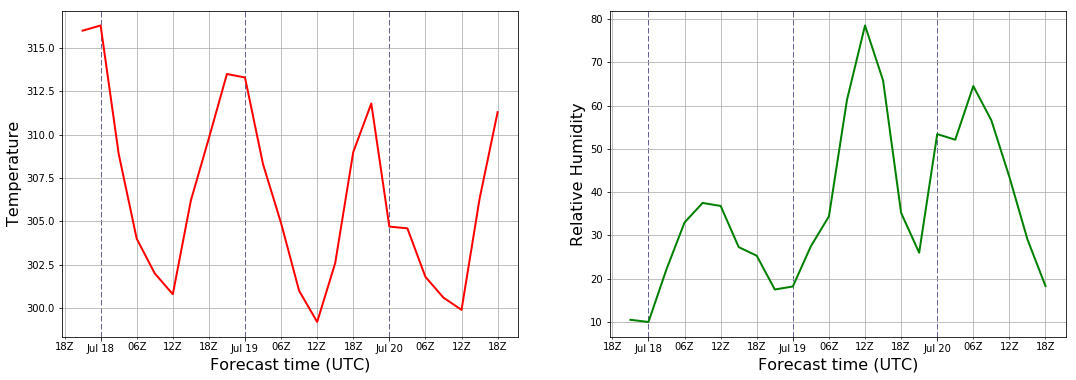

In [35]:
# Takes 'Temperature_isobaric' or 'Temperature_surface' and returns 'Temperature'
def varname_to_name(varname):
    return ' '.join(varname.split('_')[:-1])

# We add a panel to the plot and now loop over lists of axes, variable names, and plot
# styles zipped together
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
var_names = ['Temperature_isobaric', 'Relative_humidity_isobaric']
line_styles = ['r-', 'g-']
for ax, var_name, style in zip(axes, var_names, line_styles):
    ax.plot(time, data.variables[var_name][:].squeeze(), style, linewidth=2)

    # Get the basic name from the variable name
    name = varname_to_name(var_name)

    # Use the title-case version as the y-label
    ax.set_ylabel(name.title(), fontdict=dict(size=16))
    set_defaults(ax)

## Dictionaries

Dictionaries are another powerful language feature that allow you to create arbitrary mappings between two sets of things (key -> value). They can be abused, certainly, but they give programmers the ability to create simple data structures on the fly.

In [36]:
# From before, we can now create a way to map a integer value to its
# english representation
num_map = dict(zip(vals, names))
print(num_map)

{1: 'one', 2: 'two', 3: 'three', 4: 'four'}


Of course, the values can themselves be dictionaries:

In [37]:
states = dict(Colorado={'abbreviation': 'CO', 'capital': 'Denver', 'notes': 'Home!'},
              Oklahoma={'abbreviation': 'OK', 'capital': 'Oklahoma City', 'flat': True},
              Kansas={'abbreviation': 'KS', 'capital': 'Topeka', 'flat': True})

print(states['Oklahoma']['abbreviation'])

OK


Dictionaries can also be used to pass a set of keyword arguments:

In [38]:
def print_states(Colorado, **the_rest):
    print(Colorado['abbreviation'], 'is', Colorado['notes'])
    for state, info in the_rest.items():
        print('The capital of %s is %s' % (state, info['capital']))

In [39]:
print_states(**states)

CO is Home!
The capital of Oklahoma is Oklahoma City
The capital of Kansas is Topeka


Now let's add a third panel with the ``Temperature_surface``. This should have the same plotting style as ``Temperature``, but **without** duplicating the style information. It might also be nice to set the title of the axes with the variable name for clarity.

Hint: We already have ``name``, that might make a nice key


Hint #2: ``plot`` takes a bunch of keyword arguments

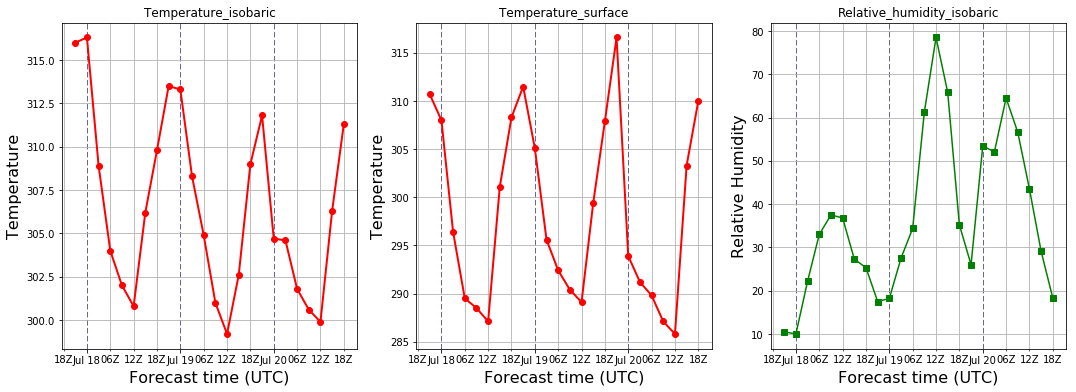

In [40]:
styles = {'Temperature': dict(color='red', marker='o', linestyle='-', linewidth=2),
          'Relative humidity': dict(color='green', marker='s')}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, varname in zip(axes, ['Temperature_isobaric', 'Temperature_surface', 'Relative_humidity_isobaric']):
    # Grab name, and use it to get styles to pass to plot
    name = varname_to_name(varname)
    ax.plot(time, data.variables[varname][:].squeeze(), **styles[name])

    ax.set_ylabel(name.title(), fontdict=dict(size=16))
    ax.set_title(varname)
    set_defaults(ax)

## First class functions

Functions in Python can be passed around and used, just like any other object. This makes it very easy to pull out bits of functionality and re-use them.

In [41]:
# Function using our dictionary from earlier
def to_english(i):
    return num_map[i]

to_english(2)

'two'

So let's sort our list of numbers using their english representation

In [42]:
vals

[1, 2, 3, 4]

In [43]:
vals.sort(key=to_english)
vals

[4, 1, 3, 2]

Let's convert the temperature on our plots from Kelvin to Farenheit. Since functions are first-class objects, we can stuff them into dictionaries as well....

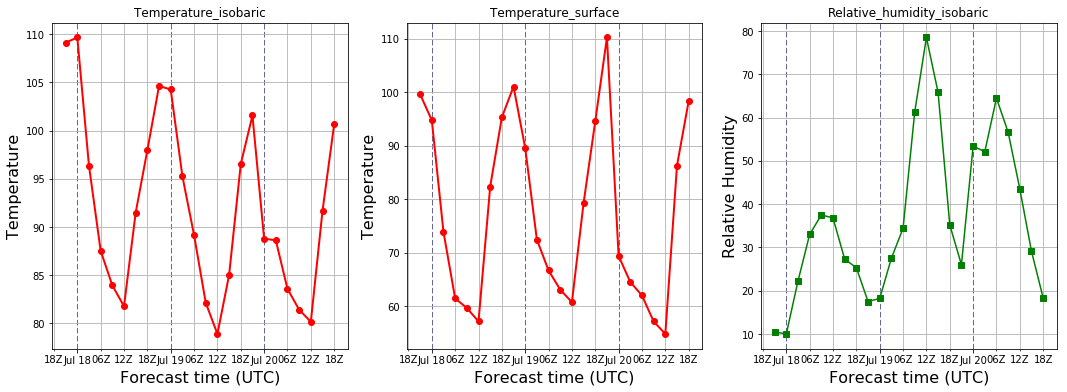

In [44]:
def K2F(K):
    return 1.8 * (K - 273.15) + 32

def donothing(x):
    return x

converters = {'Temperature': K2F, 'Relative humidity': donothing}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, varname in zip(axes, ['Temperature_isobaric', 'Temperature_surface', 'Relative_humidity_isobaric']):
    # Get the name
    name = varname_to_name(varname)

    # And the variable
    var = data.variables[varname]

    # Get the appropriate converter using the name and pass it the
    # data from the variable
    vardata = converters[name](var[:].squeeze())

    ax.plot(time, vardata, **styles[name])

    ax.set_ylabel(name.title(), fontdict=dict(size=16))
    ax.set_title(varname)
    set_defaults(ax)

## A bit more advanced

Let's now go ahead and put both temperature variables on the same plot. We'll need to change to loop over a list of `varnames` for each plot. We'll also need to label each plot with the level ``surface`` vs. ``isobaric``, and add a legend. This will also require separating out the plot styles across the type and level.

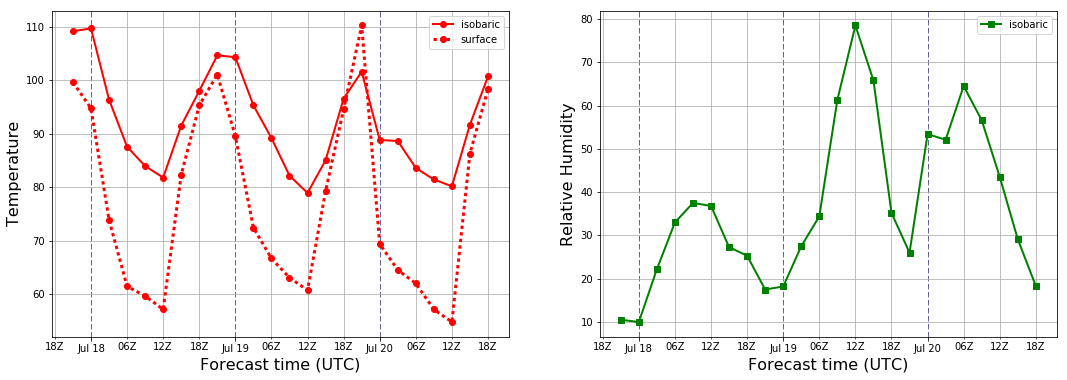

In [45]:
# Take Relative_humidity_isobaric and return ('Relative humidity', 'isobaric')
def split_varname(varname):
    parts = varname.split('_')
    name = ' '.join(parts[:-1])
    level = parts[-1]
    return name, level

type_styles = {'Temperature': dict(color='red', marker='o'),
               'Relative humidity': dict(color='green', marker='s')}

level_styles = {'isobaric': dict(linestyle='-', linewidth=2),
                'surface': dict(linestyle=':', linewidth=3)}

# Keeping converters from above
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Looping over each subplot
for ax, varnames in zip(axes, (['Temperature_isobaric', 'Temperature_surface'], ['Relative_humidity_isobaric'])):
    # Loop over each variable in a subplot
    for varname in varnames:
        # Get name and level now
        name, level = split_varname(varname)

        # Do unit conversion
        var = data.variables[varname]
        vardata = converters[name](var[:].squeeze())

        # Combine styles and plot, passing in level as the line label for the legend
        styles = type_styles[name].copy()  # so next line doesn't change original
        styles.update(level_styles[level])
        ax.plot(time, vardata, label=level, **styles)

    # These only need to be done once per subplot, not per-variable plotted
    ax.set_ylabel(name.title(), fontdict=dict(size=16))
    set_defaults(ax)
    ax.legend(loc='best')

## Filepath manipulation

The Python standard library has a lot of utilties for manipulating paths. One such utility is the ``glob`` module, which makes it easy to find files matching a UNIX shell-style file wildcard:

In [46]:
import glob
glob.glob('../../data/*.nc')

['../../data/model-gfs.nc',
 '../../data/model-nam.nc',
 '../../data/mslp.nc',
 '../../data/new.nc',
 '../../data/new2.nc',
 '../../data/prmsl.2000.nc',
 '../../data/prmsl.2001.nc',
 '../../data/prmsl.2002.nc',
 '../../data/prmsl.2003.nc',
 '../../data/prmsl.2004.nc',
 '../../data/prmsl.2005.nc',
 '../../data/prmsl.2006.nc',
 '../../data/prmsl.2007.nc',
 '../../data/prmsl.2008.nc',
 '../../data/prmsl.2009.nc',
 '../../data/prmsl.2010.nc',
 '../../data/prmsl.2011.nc',
 '../../data/rtofs_glo_3dz_f006_6hrly_reg3.nc',
 '../../data/testrh.nc']

The ``os.path`` module provides functions that make it easy to manipulate paths, making munging such information trivial. For instance, to get the base filename from those paths above:

In [47]:
import os.path
filenames = [os.path.basename(fname) for fname in glob.glob('../../data/*.nc')]
filenames

['model-gfs.nc',
 'model-nam.nc',
 'mslp.nc',
 'new.nc',
 'new2.nc',
 'prmsl.2000.nc',
 'prmsl.2001.nc',
 'prmsl.2002.nc',
 'prmsl.2003.nc',
 'prmsl.2004.nc',
 'prmsl.2005.nc',
 'prmsl.2006.nc',
 'prmsl.2007.nc',
 'prmsl.2008.nc',
 'prmsl.2009.nc',
 'prmsl.2010.nc',
 'prmsl.2011.nc',
 'rtofs_glo_3dz_f006_6hrly_reg3.nc',
 'testrh.nc']

And even remove the file extensions:

In [48]:
[os.path.splitext(name)[0] for name in filenames]

['model-gfs',
 'model-nam',
 'mslp',
 'new',
 'new2',
 'prmsl.2000',
 'prmsl.2001',
 'prmsl.2002',
 'prmsl.2003',
 'prmsl.2004',
 'prmsl.2005',
 'prmsl.2006',
 'prmsl.2007',
 'prmsl.2008',
 'prmsl.2009',
 'prmsl.2010',
 'prmsl.2011',
 'rtofs_glo_3dz_f006_6hrly_reg3',
 'testrh']

Can we use this to process all files beginning with `model-` in the `../data/` directory? Let's start by just collecting the NetCDF4 datasets into a dictionary with the model name (the part after `model-`, but before `.nc`) capitalized as the key.

In [49]:
# Create empty dict where we'll store stuff
model_data = dict()
for file in glob.glob('../../data/model-*.nc'):
    # Grab filename from pull path, then split off file extension
    basefile = os.path.splitext(os.path.basename(file))[0]

    # Grab part to right of '-' and make upper case
    modelname = basefile.split('-')[1].upper()
    print(modelname)
    
    # Open netcdf file and store under the model name
    model_data[modelname.upper()] = Dataset(file, 'r')

GFS
NAM


Now we need to update the plotting to loop over the model datasets. Note that we need to do the time conversion step from the beginning inside this loop, so that each dataset has it done. The subplots should have their title set based on the model. It might also be nice to use consistent y-axis limits for the variables.

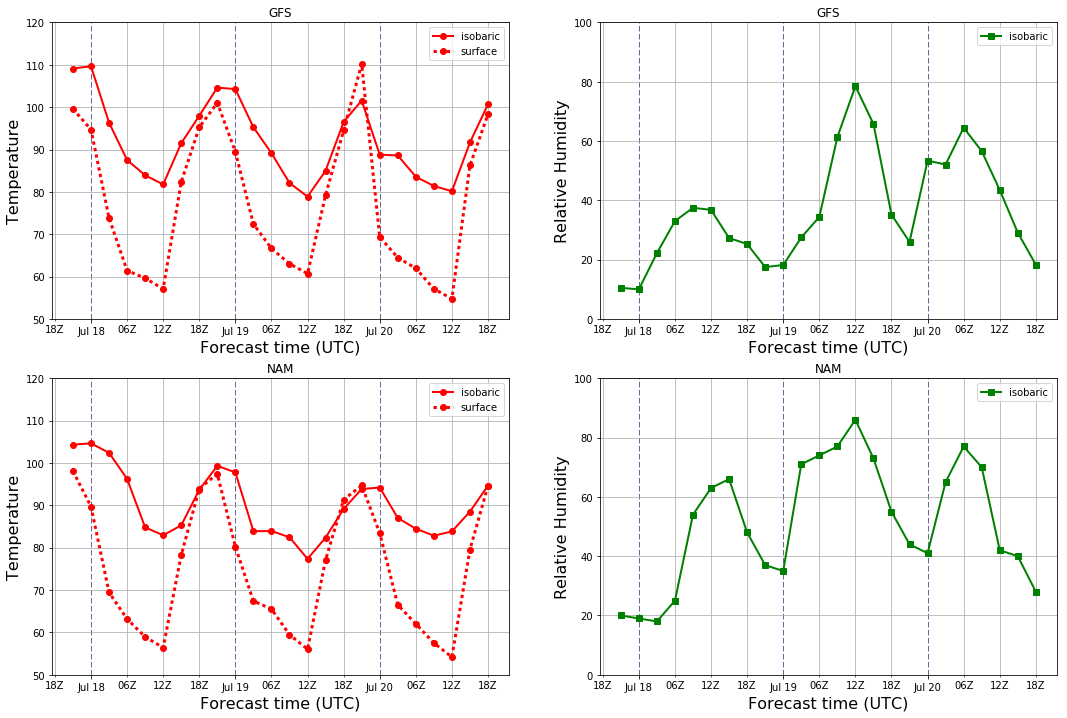

In [50]:
# Unify plot bounds
bounds = {'Temperature': (50, 120),
          'Relative humidity': (0, 100)}

# Keeping converters and styles from above
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for row, model in zip(axes, model_data):
    # Need to process each dataset here for their own time variables
    data = model_data[model]
    time_var = data['time']
    time = num2date(time_var[:], time_var.units).squeeze()

    # Now loop over each plot in the row
    for ax, varnames in zip(row, (['Temperature_isobaric', 'Temperature_surface'], ['Relative_humidity_isobaric'])):
        # And each variable in the plot
        for varname in varnames:
            name, level = split_varname(varname)
            var = data.variables[varname]
            vardata = converters[name](var[:].squeeze())

            # Plotting with combined style
            styles = type_styles[name].copy()  # so next line doesn't change original
            styles.update(level_styles[level])
            ax.plot(time, vardata, label=level, **styles)

        ax.set_xlabel('Forecast time (UTC)', fontdict=label_font)
        ax.set_ylabel(name.title(), fontdict=dict(size=16))
        set_defaults(ax)
        ax.legend(loc='best')
        ax.set_title(model)
        ax.set_ylim(*bounds[name])